In [59]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [60]:
import xarray as xr
import numpy as np
import glob
import gsw
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### get model DIC for years 1992-2012 and get climatological mean, save

### get GLODAP DIC product, convert to model units umol/L

In [61]:
prepare_data = False #switch to false if not preparing data

if prepare_data:
    def make_yearlist(yrst, yrend, dtype, tr, baseDir):
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
            t2 = glob.glob(ty)
            #print(t2)
            ylist.append(t2[0])
        return ylist

    ylist = make_yearlist(1992, 2011, 'ptrc', 'TOM12_TJ_DGA1', '/gpfs/data/greenocean/software/runs/')

    tdic = xr.open_mfdataset(ylist)

    mean_dic = tdic.groupby('time_counter.year').mean().mean(dim = ['year'])

    climatological_DIC = mean_dic.DIC
    climatological_DIC.to_netcdf('PlankTOM_DIC_1992-2012_runid-TOM12_TJ_DGA1_umolL.nc')
    

    glodap = '/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/'


    Tf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.temperature.nc')
    Sf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.salinity.nc')
    DICf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.TCO2.nc')

    T = Tf['temperature'].values #in situ
    S = Sf['salinity'].values * 35.16504/35.000 #reference salt

    pressure = np.zeros([33,180,360])
    for i in range(0,180):
        for j in range(0,360):
            pressure[:,i,j] = Tf.Depth.values

    dens = gsw.density.rho_t_exact(S, T, pressure)
    DIC = DICf.TCO2
    DIC_mu = DIC*dens/1000 #umol/kg > umol/L #conversion of glodap to model units
    DIC_mu.to_netcdf('GLODAP_DIC_2002clim_umolL.nc')
    print('done calc')

In [62]:
TOM_DIC  = xr.open_dataset('PlankTOM_DIC_1992-2012_runid-TOM12_TJ_DGA1_umolL.nc')
GLODAP_DIC = xr.open_dataset('GLODAP_DIC_2002clim_umolL.nc')

In [63]:
GLODAP_DIC

<xarray.Dataset>
Dimensions:  (depth_surface: 33, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface
Data variables:
    TCO2     (depth_surface, lat, lon) float64 ...

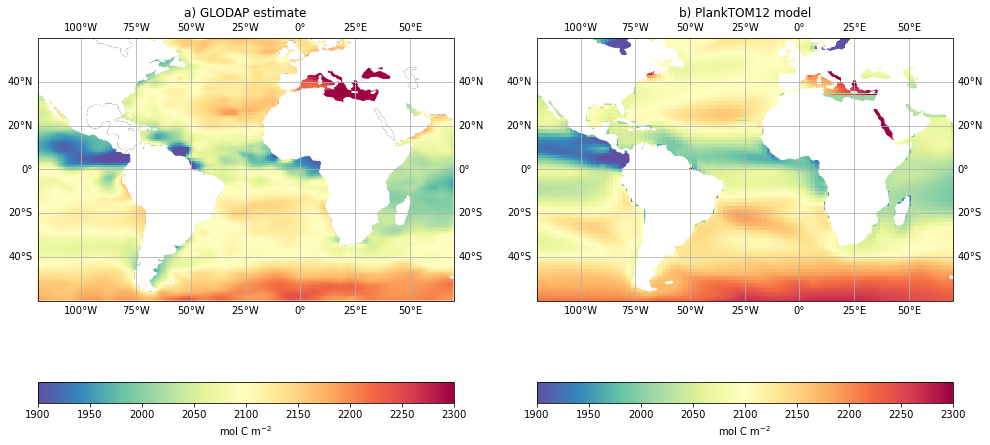

In [64]:


lonleft = -120; lonright = 70
latbot = -60; lattop = 60
tvmin = 1900; tvmax = 2300
fact = 0.8
fig = plt.figure(figsize=[20.5*fact, 12.5*fact])

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
                    
ax.coastlines()
#lons, lats extent
ax.set_extent([lonleft, lonright, latbot, lattop], crs=ccrs.PlateCarree())

mesh = ax.pcolormesh(GLODAP_DIC.lon.values, GLODAP_DIC.lat.values, GLODAP_DIC.TCO2[0,:,:], vmin = tvmin, vmax = tvmax, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'mol C m$^{-2}$')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))
ax.set_title('a) GLODAP estimate')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

### model
ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lonleft, lonright, latbot, lattop], crs=ccrs.PlateCarree())
tdat = TOM_DIC.DIC[0,:,:].values *1e6 # to umol/L
tdat[tdat == 0] = np.nan
mesh = ax.pcolormesh(TOM_DIC.nav_lon, TOM_DIC.nav_lat, tdat, vmin = tvmin, vmax = tvmax, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'mol C m$^{-2}$')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('b) PlankTOM12 model')
plt.show()

fig.savefig('GLODAP_TOM_comparison.jpg')

